In [98]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [99]:
df = pd.read_pickle('all_trips.pkl')
df.head()

,index,trip_id,bike_id,trip_duration,trip_start_time,trip_end_time,from_station,from_station_id,from_station_mode,from_lat,from_long,to_station,to_station_id,to_station_mode,to_lat,to_long
11,998695,20190311011,13022,23,2019-03-11 16:39:41,2019-03-11 17:02:49,Karl-Marx Allee,1465,station,52.5173,13.4413,Oranienplatz,1445,station,52.502,13.4162
12,998707,20190311012,13022,13,2019-03-11 17:13:53,2019-03-11 17:26:57,Oranienplatz,1445,station,52.502,13.4162,Maybachufer,1589,station,52.4896,13.4391
14,922715,20190311014,13023,75,2019-03-11 08:47:44,2019-03-11 10:03:18,Helsingforser Platz,1458,station,52.5078,13.4496,BIKE 13023,0,floating,52.4862,13.3765
18,451393,20190311018,13026,11,2019-03-11 23:06:53,2019-03-11 23:17:57,BIKE 13026,0,floating,52.5473,13.4094,U Senefelder Platz,1543,station,52.5329,13.4124
20,888466,20190311020,13028,29,2019-03-11 09:04:53,2019-03-11 09:34:05,Sonnenallee/Innstraße,1609,station,52.4806,13.4428,BIKE 13028,0,floating,52.5015,13.4111


### Day of Week

c:\users\steff\anaconda3\envs\tf\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


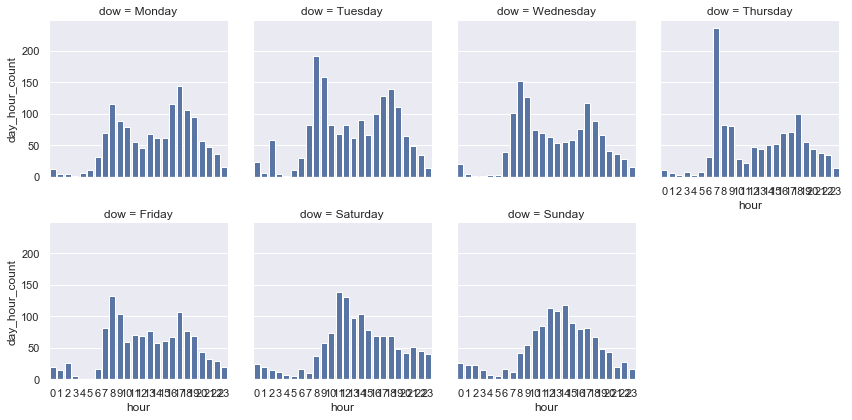

In [100]:
df['dow'] = df.trip_start_time.dt.day_name()
df['hour'] = df.trip_start_time.dt.hour
ax  = sns.FacetGrid(data=df.groupby([
    'dow',
    'hour'
]).hour.count().to_frame(name='day_hour_count').reset_index(), col='dow', col_order=[
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday'
], col_wrap=4)
ax.map(sns.barplot, 'hour', 'day_hour_count');

### Predict

In [101]:
daily = df.set_index('trip_start_time').groupby(pd.Grouper(freq='D')).size()
daily = pd.DataFrame(daily)
daily = daily.reset_index()
daily.columns = ['ds', 'y']
daily.head()

,ds,y
0,2019-03-11,313
1,2019-03-12,543
2,2019-03-13,566
3,2019-03-14,439
4,2019-03-15,513


In [102]:
m = Prophet()
m.fit(daily)

c:\users\steff\anaconda3\envs\tf\lib\site-packages\fbprophet\forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 11.0.
c:\users\steff\anaconda3\envs\tf\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [103]:
future = m.make_future_dataframe(periods=5)
future.tail()

,ds
16,2019-03-27
17,2019-03-28
18,2019-03-29
19,2019-03-30
20,2019-03-31


In [104]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.to_pickle('forecast.pkl')

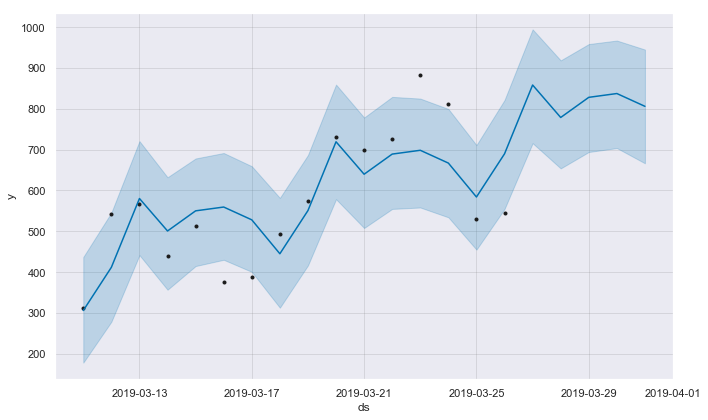

In [105]:
fig1 = m.plot(forecast)

### Hourly

In [124]:
hourly = df.set_index('trip_start_time').groupby(pd.Grouper(freq='2h')).size()
hourly = pd.DataFrame(hourly)
hourly = hourly.reset_index()
hourly.columns = ['ds', 'y']
hourly.head()

,ds,y
0,2019-03-11 08:00:00,47
1,2019-03-11 10:00:00,40
2,2019-03-11 12:00:00,25
3,2019-03-11 14:00:00,42
4,2019-03-11 16:00:00,80


In [125]:
mh = Prophet()
mh.fit(hourly)

c:\users\steff\anaconda3\envs\tf\lib\site-packages\fbprophet\forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\users\steff\anaconda3\envs\tf\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [126]:
futureh = mh.make_future_dataframe(periods=120)
futureh.tail()

,ds
303,2019-07-20 22:00:00
304,2019-07-21 22:00:00
305,2019-07-22 22:00:00
306,2019-07-23 22:00:00
307,2019-07-24 22:00:00


In [127]:
forecasth = mh.predict(future)
forecasth[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
16,2019-03-27,39.381837,-1.277709,78.241586
17,2019-03-28,41.561484,1.236218,80.729866
18,2019-03-29,37.720070,-0.068566,78.134474
19,2019-03-30,41.450081,3.738703,79.512384
20,2019-03-31,42.410231,6.704974,80.977459


In [128]:
forecasth.to_pickle('forecast_hourly.pkl')

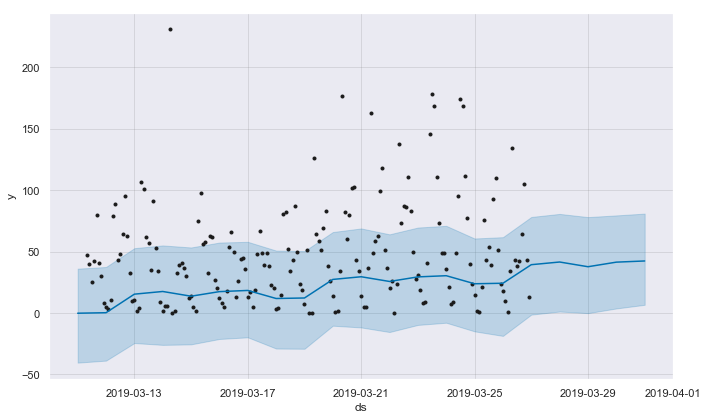

In [129]:
figh = mh.plot(forecasth)